In [128]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 8, 4

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Credit_Card_data = pd.read_csv(r"C:\Users\16474\Downloads\CreditCardDataset.csv")
Credit_Card_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
1,2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
2,7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
3,11,1.069374,0.287722,0.828613,2.712520,-0.178398,0.337544,-0.096717,0.115982,-0.221083,...,-0.036876,0.074412,-0.071407,0.104744,0.548265,0.104094,0.021491,0.021293,27.50,0
4,12,-0.752417,0.345485,2.057323,-1.468643,-1.158394,-0.077850,-0.608581,0.003603,-0.436167,...,0.499625,1.353650,-0.256573,-0.065084,-0.039124,-0.087086,-0.180998,0.129394,15.99,0


In [55]:
pip install torchvision 

     ---------------------------------------- 1.1/1.1 MB 6.9 MB/s eta 0:00:00
     -------------------------------------- 167.2/167.2 MB 8.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1. EDA and data preprocessing

In [111]:
Credit_Card_data.shape

(57355, 31)

In [112]:
Credit_Card_data.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57355 entries, 0 to 57354
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    57355 non-null  int64  
 1   V1      57355 non-null  float64
 2   V2      57355 non-null  float64
 3   V3      57355 non-null  float64
 4   V4      57355 non-null  float64
 5   V5      57355 non-null  float64
 6   V6      57355 non-null  float64
 7   V7      57355 non-null  float64
 8   V8      57355 non-null  float64
 9   V9      57355 non-null  float64
 10  V10     57355 non-null  float64
 11  V11     57355 non-null  float64
 12  V12     57355 non-null  float64
 13  V13     57355 non-null  float64
 14  V14     57355 non-null  float64
 15  V15     57355 non-null  float64
 16  V16     57355 non-null  float64
 17  V17     57355 non-null  float64
 18  V18     57355 non-null  float64
 19  V19     57355 non-null  float64
 20  V20     57355 non-null  float64
 21  V21     57355 non-null  float64
 22

In [113]:
Credit_Card_data[['Time', 'Amount', 'Class']].describe()

,Time,Amount,Class
count,57355.000000,57355.000000,57355.000000
mean,94577.357074,88.825575,0.008578
std,47505.713234,279.496913,0.092221
min,2.000000,0.000000,0.000000
25%,53943.500000,5.475000,0.000000
50%,84641.000000,21.990000,0.000000
75%,139140.000000,76.900000,0.000000
max,172777.000000,25691.160000,1.000000


By describing, we can get all the statistical information for the numeric columns and get an idea about their distribution and outliers.

After all the data inspecting, let’s check for the null values,

In [114]:
Credit_Card_data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

There is no any null value.

##### Observe the distribution of our classes

In [115]:
classes=Credit_Card_data['Class'].value_counts()
normal_share=round(classes[0]/df['Class'].count()*100,2)
fraud_share=round(classes[1]/df['Class'].count()*100, 2)
print("Non-Fraudulent : {} %".format(normal_share))
print("    Fraudulent : {} %".format(fraud_share))

Non-Fraudulent : 99.14 %
    Fraudulent : 0.86 %


In [116]:
Credit_Card_data['Class'].value_counts()

0    56863
1      492
Name: Class, dtype: int64

Class distribution 
* 0 - non fraudulent
* 1 - fraudulent

C:\Users\16474\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


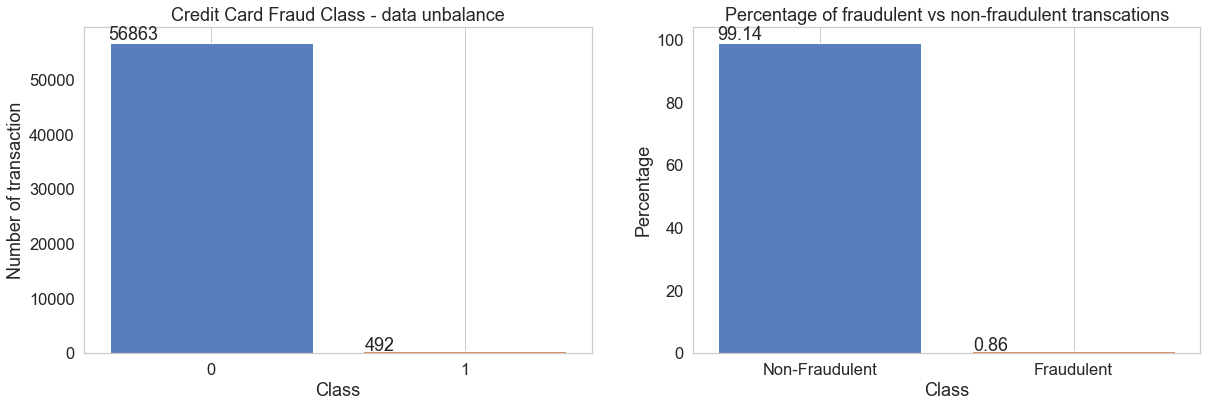

In [129]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations


plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
ax=sns.countplot(Credit_Card_data["Class"])
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
plt.ylabel("Number of transaction")
plt.xlabel("Class")
plt.title("Credit Card Fraud Class - data unbalance")
plt.grid()
plt.subplot(1,2,2)
fraud_percentage = {'Class':['Non-Fraudulent', 'Fraudulent'], 'Percentage':[normal_share, fraud_share]} 
df_fraud_percentage = pd.DataFrame(fraud_percentage) 
ax=sns.barplot(x='Class',y='Percentage', data=df_fraud_percentage)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
plt.title('Percentage of fraudulent vs non-fraudulent transcations')

plt.grid()

The dataset has very high class imbalance. Only 492 records are there among 56863 records which are labeld as fradudulent transaction. That means the data is highly unbalanced with respect with target variable Class.

C:\Users\16474\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


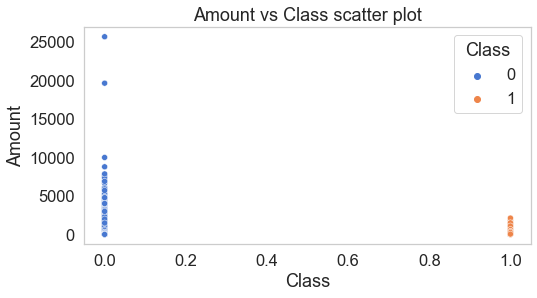

In [130]:
# Create a scatter plot to observe the distribution of classes with Amount

sns.scatterplot(Credit_Card_data["Class"],Credit_Card_data["Amount"],hue=Credit_Card_data["Class"])
plt.title("Amount vs Class scatter plot")
plt.grid()

Clearly low amount transactions are more likely to be fraudulent than high amount transaction.

C:\Users\16474\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


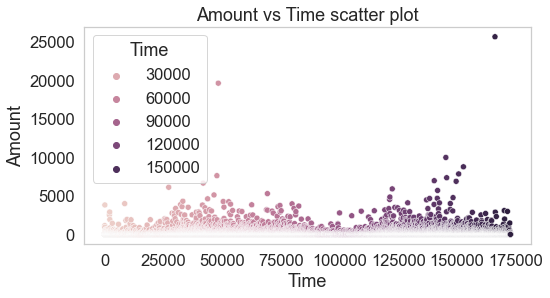

In [131]:
# Create a scatter plot to observe the distribution of time with Amount

sns.scatterplot(Credit_Card_data["Time"],Credit_Card_data["Amount"],hue=Credit_Card_data["Time"])
plt.title("Amount vs Time scatter plot")
plt.grid()

So, it is clear that time of transaction has no effects on the fraudulent activity. So, let's drop 'Time' column.

In [132]:
df = Credit_Card_data.drop(['Time'], axis=1)

standardize the feature Amount...

In [133]:
from sklearn.preprocessing import StandardScaler

In [134]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

#### balance the fraud and legitimate transactions in data

In [135]:
X = df.drop(labels='Class', axis=1) # Features
y = df.loc[:,'Class']               # Target Variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [136]:
# Use Synthetic Minority Oversampling
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [137]:
from sklearn.feature_selection import mutual_info_classif
mutual_infos = pd.Series(data=mutual_info_classif(X_res, y_res, discrete_features=False, random_state=1), index=X_train.columns)

In [138]:
mutual_infos.sort_values(ascending=False)

V14       0.504767
V17       0.453140
V10       0.441237
V12       0.434955
V11       0.413043
V4        0.398509
V3        0.363233
V16       0.359878
V7        0.325388
V2        0.291951
Amount    0.270193
V9        0.265474
V21       0.261308
V27       0.229123
V18       0.216457
V1        0.216314
V6        0.191036
V28       0.175586
V5        0.164565
V8        0.161617
V19       0.136908
V20       0.122253
V23       0.069266
V24       0.067188
V26       0.046627
V25       0.031228
V22       0.025993
V13       0.020144
V15       0.014936
dtype: float64

C:\Users\16474\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Class', ylabel='count'>

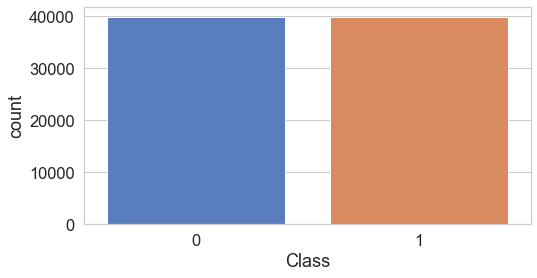

In [139]:
sns.countplot(y_res)

Hence, we can say that the most correlated features after resolving class imbalance using Synthetic Minority Oversampling are V14, V10, V4, V12 and V17.

### 2. Implement a Neural Network using PyTorch Framework
 

##### Split the dataset in training and test datasets

In [140]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values

X_test = X_test.values
y_test = y_test.values
print(y_test.size)

11471


creating model...

In [141]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(29, 14),
            nn.Tanh(),
            nn.Linear(14, 7),
            nn.LeakyReLU(),
            )
        
        self.decoder = nn.Sequential(
           nn.Linear(7, 7),
           nn.Tanh(),
           nn.Linear(7, 29),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [142]:
model = Autoencoder().double().cpu()
num_epochs = 100
minibatch_size = 32
learning_rate = 1e-3

In [143]:
train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)

test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)


In [144]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)


In [145]:
history = {}
history['train_loss'] = []
history['test_loss'] = []

In [146]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
   
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)
    

torch.save(model.state_dict(), './credit_card_model.pth')

epoch [1/100], loss:0.9294
epoch [2/100], loss:0.8409
epoch [3/100], loss:0.8082
epoch [4/100], loss:0.7892
epoch [5/100], loss:0.7805
epoch [6/100], loss:0.7740
epoch [7/100], loss:0.7693
epoch [8/100], loss:0.7652
epoch [9/100], loss:0.7620
epoch [10/100], loss:0.7589
epoch [11/100], loss:0.7561
epoch [12/100], loss:0.7543
epoch [13/100], loss:0.7526
epoch [14/100], loss:0.7507
epoch [15/100], loss:0.7496
epoch [16/100], loss:0.7478
epoch [17/100], loss:0.7465
epoch [18/100], loss:0.7459
epoch [19/100], loss:0.7443
epoch [20/100], loss:0.7438
epoch [21/100], loss:0.7406
epoch [22/100], loss:0.7393
epoch [23/100], loss:0.7383
epoch [24/100], loss:0.7380
epoch [25/100], loss:0.7371
epoch [26/100], loss:0.7547
epoch [27/100], loss:0.7364
epoch [28/100], loss:0.7353
epoch [29/100], loss:0.7328
epoch [30/100], loss:0.7314
epoch [31/100], loss:0.7309
epoch [32/100], loss:0.7303
epoch [33/100], loss:0.7303
epoch [34/100], loss:0.7301
epoch [35/100], loss:0.7298
epoch [36/100], loss:0.7296
e

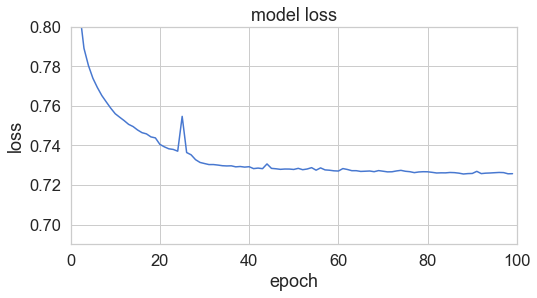

In [147]:

plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0,100,0.69,0.80])

plt.show()

#### Evaluation

In [148]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
   
    for data in test_loader:
        inputs = data
        
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        
        pred_losses['pred_loss'].append(loss)
        
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test

In [149]:
reconstructionErrorDF.describe()

,pred_loss,Class
count,11471.000000,11471.000000
mean,0.874759,0.007061
std,4.967747,0.083738
min,0.046236,0.000000
25%,0.236210,0.000000
50%,0.378914,0.000000
75%,0.609371,0.000000
max,276.227979,1.000000


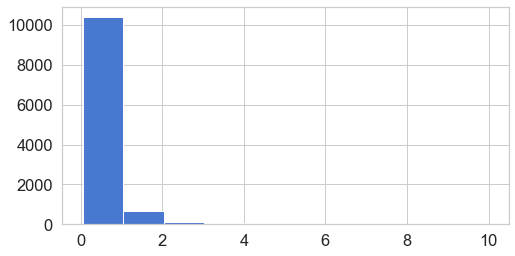

In [150]:
# Reconstruction Errors without Fraud



fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 0) & (reconstructionErrorDF['pred_loss'] < 10)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

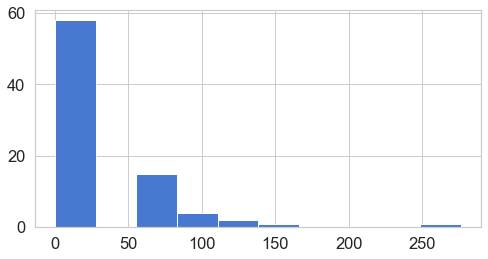

In [151]:
# Reconstruction Errors with Fraud



fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

 #### ROC Curves

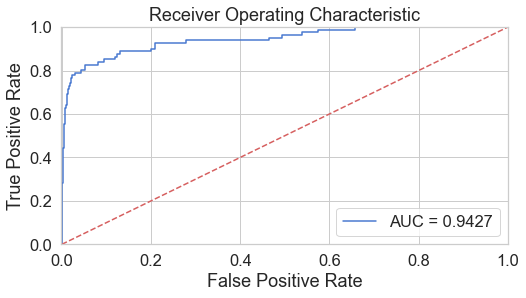

In [152]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

#### Precision vs Recall

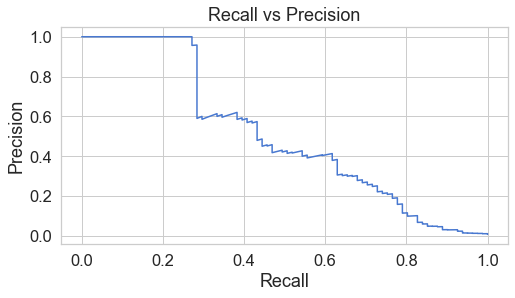

In [153]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

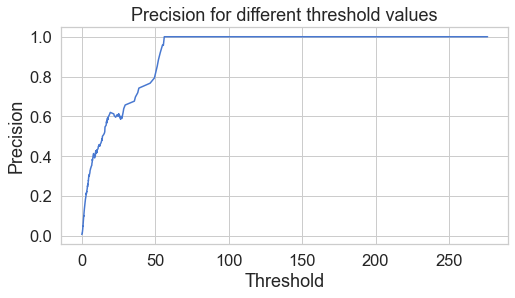

In [154]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

 here, the reconstruction error increases our precision rises as well.

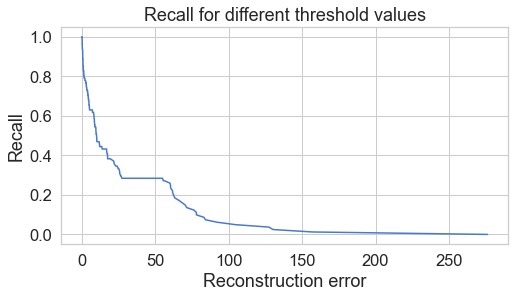

In [155]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, there is an opposite situation. As the reconstruction error increases the recall decreases.

#### Predicting the model

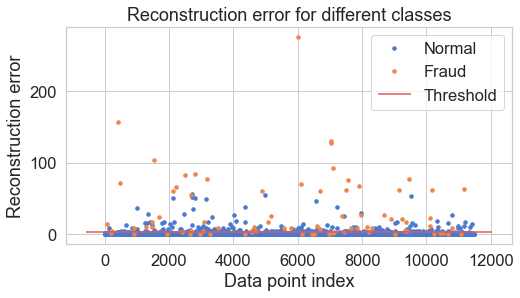

In [156]:
threshold = 2.9

groups = reconstructionErrorDF.groupby('Class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

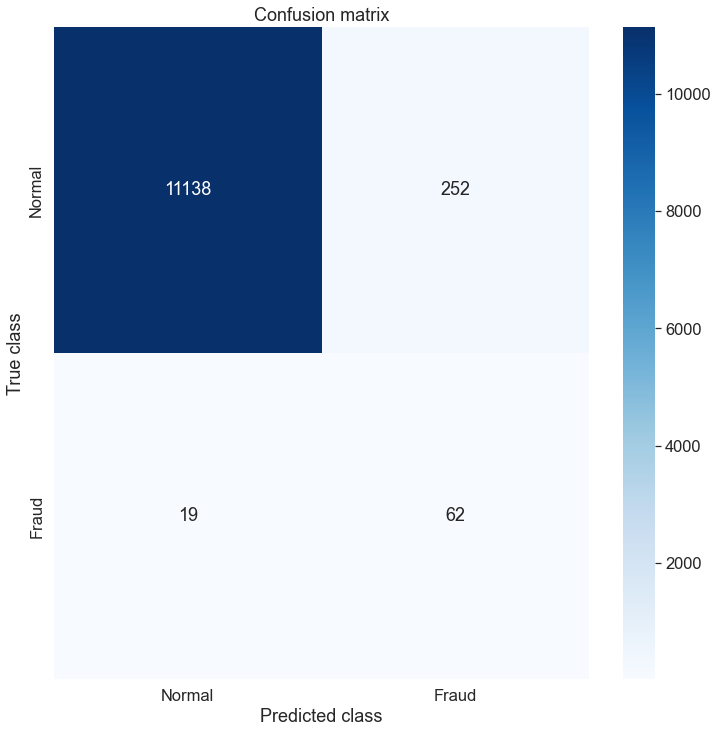

In [157]:
# confusion matrix

y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.Class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", 
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### 3. Conclusion

* All Fraud Transactions occur for an amount below 2500. Thus, the bank can infer clearly that the fraud committers try to commit frauds of smaller amounts to avoid suspicion.
* The fraud transactions are equitable distributed throughout time and there is no clear relationship of time with commiting of fraud.
* The number of fraud transactions are very few comparted to legitimate transactions and it has to be balanced in order for a fair comparison to prevent the model from overfitting.